In [1]:
# Import modules
import sys
sys.path.append(r"c:/Users/Raees/Desktop/stuff/NuOscProbExact/src")

from oscprob2nu import *
from globaldefs import *
from hamiltonians2nu import *
from hamiltonians3nu import *
from oscprob3nu import *

import numpy as np 
import matplotlib.pyplot as plt
import math
from scipy.stats import truncnorm
from scipy.optimize import curve_fit
import scipy.integrate as integrate
from scipy.integrate import simpson, quad
from scipy.interpolate import interp1d
import copy as cp
import builtins
import itertools
import scipy.linalg as la
from scipy.linalg import expm
import cmath
from scipy.stats import chisquare, ks_2samp, pearsonr
from scipy.stats import wasserstein_distance
from scipy.stats import entropy
from scipy.spatial.distance import cdist

In [2]:
def gaus(data, amplitude, mean, sigma):
    return amplitude * math.e**((-0.5 * (data - mean)**2) / sigma**2)

def fluctuated_fit(gaus, bin_centers, counts):
    popt, _ = curve_fit(gaus, bin_centers, counts)
    return popt

def param_values2(param=None, sigma_fraction=0.0):
    """
    Returns oscillation parameter values at a given fraction of their uncertainty.

    Args:
        param (str): Name of the parameter.
        sigma_fraction (float): Fraction of the uncertainty (-1 to 1 for ±1σ).

    Returns:
        float: Parameter value adjusted by the given fraction of uncertainty.
    """

    params = {
        'Dm2_21': (7.53e-5, 0.0),  # No uncertainty specified
        's2th12': (0.307, 0.0),  # No uncertainty specified
        's2th13': (0.0210, 0.0011),  # ± 0.0011
        'Dm2_32': (2.41e-3, 0.07e-3),  # ± 0.07e-3
        's2th23': (0.57, 0.03, 0.04),  # +0.03, -0.04
        'd_cp': (0.82 * np.pi, 0.27 * np.pi, 0.87 * np.pi)  # +0.27π, -0.87π
    }

    if param not in params:
        raise ValueError(f"Invalid parameter: {param}")

    central = params[param][0]

    if len(params[param]) == 2:
        uncertainty = params[param][1]

        if param in ['s2th13', 's2th12']:
            return np.sqrt(central + (sigma_fraction * uncertainty))
        else:

            return central + (sigma_fraction * uncertainty)

    elif len(params[param]) == 3:
        pos_unc = params[param][1]
        neg_unc = params[param][2]

        if param in ['s2th23']:
            return np.sqrt(central + sigma_fraction * (pos_unc if sigma_fraction > 0 else neg_unc))
        else:
            return central + sigma_fraction * (pos_unc if sigma_fraction > 0 else neg_unc)

    return central



In [3]:
# Parameters
bin_centers = np.array([0.375, 0.875, 1.05, 1.15, 1.25, 1.35, 1.45, 1.55, 1.65, 1.75, 1.85, 1.95, 2.125, 2.375, 2.6375, 2.8875, 3.25, 3.75, 4.5])
bin_edges = np.array([0, 0.75, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.25, 2.5, 2.775, 3, 3.5, 4, 5])

# Event counts for muon neutrino beam, muon-to-muon
counts_nd = np.array([5, 42, 72, 96, 120, 148, 170, 192, 208, 214, 212, 204, 170, 112, 66, 36, 16, 5, 1])
counts_fd = np.array([0, 3, 1, 3, 1, 2, 2, 4, 6, 9, 15, 12, 15.8, 10, 7, 9, 3.2, 2.8, 1.8])
adjusted_counts_fd = np.array([ 0.  ,  7.5 ,  1.  ,  3.  ,  1.  ,  2.  ,  2.  ,  4.  ,  6.  ,
        9.  , 15.  , 12.  , 39.5 , 25.  , 19.25, 20.25, 16.  , 14.  ,
       18.  ])
adjusted_counts_nd = np.array([ 37500., 105000.,  72000.,  96000., 120000., 148000., 170000.,
       192000., 208000., 214000., 212000., 204000., 425000., 280000.,
       181500.,  81000.,  80000.,  25000.,  10000.])

# Event counts for electron neutrio beam, muon-to-electron
counts_nd_e = np.array([0.01, 0.5, 2.4, 4.6, 4, 2.6, 1.8 ,1.4, 1.2])
adjusted_counts_nd_e = np.array([10, 500, 2400, 4600, 400, 2600, 1800, 1400, 1200])
counts_fd_e = np.array([5 ,21, 18, 4, 1, 1])
bin_centers_e = np.array([0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25])
bin_edges_e = np.array([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5])

length_nd = 1 # [km]
length_fd = 810 # [km]

bin_widths = bin_edges[1:] - bin_edges[:-1]

# Event counts for antineutrino beam
anti_counts_nd = np.array([2.5, 20, 38.75, 45 ,67.5, 70, 85, 97.5, 107.5, 113.75, 115, 111.25, 95, 62.5, 37.5, 20, 10, 2.5, 0])
anti_counts_fd = np.array([0.25, 2, 1, 2, 0, 2, 3, 0, 0, 8, 3, 7, 4.4, 6, 2.4, 2, 2.4, 1.25, 1.75])
anti_counts_nd_e = np.array([0, 0.25, 1.3, 2.5, 2.52, 1.9, 1.35, 1.15, 0.95]) # The High CNN one, cause it might be better?
anti_counts_fd_e = np.array([1, 8, 5, 3, 1, 1])

adjusted_anti_counts_nd_e = np.array([0, 250, 1300, 2500, 2520, 1900, 1350, 1150, 950])
adjusted_anti_counts_nd = anti_counts_nd * (bin_widths / 0.1) * 1000
adjusted_anti_counts_fd = anti_counts_fd * (bin_widths / 0.1)

print(adjusted_anti_counts_fd)

initial_guess = [140, 2, 0.5]

popt_nd, _ = curve_fit(gaus, bin_centers, counts_nd, p0=initial_guess)
print(f"Fitted parameters for observed the unoscillated ND events: Amplitude = {popt_nd[0]}, Mean = {popt_nd[1]}, Sigma = {popt_nd[2]}")


popt_nd_e, _ = curve_fit(gaus, bin_centers_e, counts_nd_e, p0=[5,2, 0.5])
print(f"Fitted parameters for observed the unoscillated ND electon events: Amplitude = {popt_nd_e[0]}, Mean = {popt_nd_e[1]}, Sigma = {popt_nd_e[2]}")

popt_anti_nd, _ = curve_fit(gaus, bin_centers, anti_counts_nd, p0=[120,2,0.5])
print(f"Fitted parameters for observed the unoscillated antineutrino ND events: Amplitude = {popt_anti_nd[0]}, Mean = {popt_anti_nd[1]}, Sigma = {popt_anti_nd[2]}")


popt_anti_nd_e, _ = curve_fit(gaus, bin_centers_e, anti_counts_nd_e, p0=[5,2,0.5])
print(f"Fitted parameters for observed the unoscillated antineutrino ND electron events: Amplitude = {popt_anti_nd_e[0]}, Mean = {popt_anti_nd_e[1]}, Sigma = {popt_anti_nd_e[2]}")

x = np.arange(0.01,5,0.01)

[ 1.875  5.     1.     2.     0.     2.     3.     0.     0.     8.
  3.     7.    11.    15.     6.6    4.5   12.     6.25  17.5  ]
Fitted parameters for observed the unoscillated ND events: Amplitude = 212.76692701207105, Mean = 1.8044188236034169, Sigma = 0.525448417032163
Fitted parameters for observed the unoscillated ND electon events: Amplitude = 4.218662147714044, Mean = 2.1341687610051183, Sigma = 0.8475810459857663
Fitted parameters for observed the unoscillated antineutrino ND events: Amplitude = 113.1060196955553, Mean = 1.8355298839724858, Sigma = 0.5285564990530245
Fitted parameters for observed the unoscillated antineutrino ND electron events: Amplitude = 2.4344413635605364, Mean = 2.356842604598921, Sigma = 0.9997075655274238


In [ ]:
def osc_prob_2nu_fd2(mixing_angle_23, delta_mass_squared_32):
    mixing_angle_12 = np.sqrt(0.307)
    delta_mass_squared_12 = 7.53e-5

    energy = x * 1e9  # Convert to eV
    length_scaled_nd = length_nd * CONV_KM_TO_INV_EV
    length_scaled_fd = length_fd * CONV_KM_TO_INV_EV

    cases = ['vacuum', 'matter']
    types = ['neutrino', 'antineutrino']

    # Precompute Hamiltonians (energy-independent)
    h_mm_nd = hamiltonian_2nu_vacuum_energy_independent(mixing_angle_12, delta_mass_squared_12)
    h_me_nd = hamiltonian_2nu_vacuum_energy_independent(mixing_angle_12, delta_mass_squared_12)
    h_me_fd = h_me_nd

    h_mm_fd = hamiltonian_2nu_vacuum_energy_independent(mixing_angle_23, delta_mass_squared_32)
    h_mt_fd = hamiltonian_2nu_vacuum_energy_independent(mixing_angle_23, delta_mass_squared_32)

    # Store results
    all_counts = {}

    for case in cases:
        for particle_type in types:
            if case == 'vacuum':
                def calculate_hamiltonian(h, e): return h / e
            else:  # matter case
                def calculate_hamiltonian(h, e): return hamiltonian_2nu_matter(h, e, VCC_EARTH_CRUST)

            # Compute probabilities using vectorized NumPy operations
            prob_nd = np.array([
                probabilities_2nu(calculate_hamiltonian(h_mm_nd, e), length_scaled_nd)
                for e in energy
            ])
            prob_nd_e = np.array([
                probabilities_2nu(calculate_hamiltonian(h_me_nd, e), length_scaled_fd)
                for e in energy
            ])
            prob_fd = np.array([
                probabilities_2nu(calculate_hamiltonian(h_mm_fd, e), length_scaled_fd)
                for e in energy
            ])

            prob_me_nd, prob_mm_nd = prob_nd[:, 2], prob_nd[:, 3]
            prob_mm_fd, prob_mt_fd = prob_fd[:, 0], prob_fd[:, 1]
            prob_me_fd = prob_nd_e[:,2]

            # Select Gaussian parameters
            if particle_type == 'neutrino':
                popt_me, bin_edges_me = popt_nd, bin_edges
                popt_mm, bin_edges_mm = popt_nd, bin_edges
            else:  # antineutrino
                popt_me, bin_edges_me = popt_anti_nd, bin_edges
                popt_mm, bin_edges_mm = popt_anti_nd, bin_edges

            # Compute Gaussian fits
            gaus_me_nd = prob_me_nd * gaus(x, *popt_me)
            gaus_me_fd = prob_me_fd * gaus(x, *popt_me)
            gaus_mm_nd = prob_mm_nd * gaus(x, *popt_mm)
            gaus_mm_fd = prob_mm_fd * gaus(x, *popt_mm)
            gaus_mt_fd = prob_mt_fd * gaus(x, *popt_mm)

            # Interpolation functions
            gf_me_nd, gf_me_fd = interp1d(x, gaus_me_nd, fill_value=0, bounds_error=False), interp1d(x, gaus_me_fd, fill_value=0, bounds_error=False)
            gf_mm_nd, gf_mm_fd = interp1d(x, gaus_mm_nd, fill_value=0, bounds_error=False), interp1d(x, gaus_mm_fd, fill_value=0, bounds_error=False)
            gf_mt_fd = interp1d(x, gaus_mt_fd, fill_value=0, bounds_error=False)

            # Compute areas via integration
            areas_mm_nd = np.array([quad(gf_mm_nd, bin_edges_mm[i], bin_edges_mm[i+1])[0] for i in range(len(bin_edges_mm) - 1)])
            areas_mm_fd = np.array([quad(gf_mm_fd, bin_edges_mm[i], bin_edges_mm[i+1])[0] for i in range(len(bin_edges_mm) - 1)])
            areas_mt_fd = np.array([quad(gf_mt_fd, bin_edges_mm[i], bin_edges_mm[i+1])[0] for i in range(len(bin_edges_mm) - 1)])

            areas_me_nd = np.array([quad(gf_me_nd, bin_edges_me[i], bin_edges_me[i+1])[0] for i in range(len(bin_edges_me) - 1)])
            areas_me_fd = np.array([quad(gf_me_fd, bin_edges_me[i], bin_edges_me[i+1])[0] for i in range(len(bin_edges_me) - 1)])

            bin_widths_mm = np.diff(bin_edges_mm)
            bin_widths_me = np.diff(bin_edges_me)

            # Compute counts
            if particle_type == 'neutrino':
                counts_mm_nd = areas_mm_nd / bin_widths_mm
                counts_mm_fd = (areas_mm_fd / bin_widths_mm) * (np.sum(adjusted_counts_fd) / np.sum(adjusted_counts_nd)) * (1000 * np.sum(gaus_mm_nd) / np.sum(gaus_mm_fd))
                counts_mt_fd = (areas_mt_fd / bin_widths_mm) * (np.sum(adjusted_counts_fd) / np.sum(adjusted_counts_nd)) * (1000 * np.sum(gaus_mm_nd) / np.sum(gaus_mm_fd))

                counts_me_nd = areas_me_nd / bin_widths_me
                counts_me_fd = (areas_me_fd / bin_widths_me) * (np.sum(counts_fd_e) / np.sum(adjusted_counts_nd_e)) * ((np.sum(gaus_me_nd) / np.sum(gaus_me_fd)))
                
            else:  # antineutrino
                counts_mm_nd = areas_mm_nd / bin_widths_mm
                counts_mm_fd = (areas_mm_fd / bin_widths_mm) * (np.sum(adjusted_anti_counts_fd) / np.sum(adjusted_anti_counts_nd)) * (1000 * np.sum(gaus_mm_nd) / np.sum(gaus_mm_fd))
                counts_mt_fd = (areas_mt_fd / bin_widths_mm) * (np.sum(adjusted_anti_counts_fd) / np.sum(adjusted_anti_counts_nd)) * (1000 * np.sum(gaus_mm_nd) / np.sum(gaus_mm_fd))

                counts_me_nd = areas_me_nd / bin_widths_me
                counts_me_fd = (areas_me_fd / bin_widths_me) * (np.sum(anti_counts_fd_e) / np.sum(adjusted_anti_counts_nd_e)) * ((np.sum(gaus_me_nd) / np.sum(gaus_me_fd)))

            # Store results
            all_counts[(particle_type, case)] = (counts_mm_nd, counts_mm_fd, counts_mt_fd, counts_me_nd, counts_me_fd)

    return all_counts

In [5]:
from joblib import Parallel, delayed
import pandas as pd

def evaluate_params(angle, delta, input):
    results = osc_prob_2nu_fd2(angle, delta)

    if input == 'counts_fd':
        real_counts = counts_fd
        _, counts, _, _, _ = results[('neutrino', 'vacuum')]
    elif input == 'anti_counts_fd':
        real_counts = anti_counts_fd
        _, counts, _, _, _ = results[('antineutrino', 'vacuum')]
    else:
        raise ValueError("Invalid input")

    emd = wasserstein_distance(real_counts, counts)

    epsilon = 1e-15
    chi_squared = np.sum(((real_counts - counts) ** 2) / (real_counts + counts + epsilon))

    hist1_norm = real_counts / real_counts.sum()
    hist2_norm = counts / counts.sum()
    kl_divergence = entropy(hist1_norm, hist2_norm)

    average_distance = np.mean([emd, chi_squared, kl_divergence])

    return {
        'angle': angle,
        'delta': delta,
        'emd': emd,
        'chi_squared': chi_squared,
        'kl_divergence': kl_divergence,
        'average_distance': average_distance
    }

def best_fit_params_mm_fd2(input):
    mixing_angle_23_range = np.linspace(0.25, 0.85, 60) # You can expand this if needed
    delta_mass_squared_32_range = np.linspace(1.7e-3, 2.7e-3, 100)

    param_grid = [(angle, delta) for angle in mixing_angle_23_range for delta in delta_mass_squared_32_range]

    results = Parallel(n_jobs=-1, backend='loky')(
        delayed(evaluate_params)(angle, delta, input) for angle, delta in param_grid
    )

    results_df = pd.DataFrame(results)

    # Find best fits for each metric
    best_by_avg = min(results, key=lambda x: x['average_distance'])
    best_by_emd = min(results, key=lambda x: x['emd'])
    best_by_chi2 = min(results, key=lambda x: x['chi_squared'])
    best_by_kld = min(results, key=lambda x: x['kl_divergence'])

    best_params = (best_by_avg['angle'], best_by_avg['delta'])
    best_params_emd = (best_by_emd['angle'], best_by_emd['delta'])
    best_params_chi2 = (best_by_chi2['angle'], best_by_chi2['delta'])
    best_params_kld = (best_by_kld['angle'], best_by_kld['delta'])

    return best_params, best_params_emd, best_params_chi2, best_params_kld, results_df

In [33]:
best_params, best_params_emd, best_params_chi2, best_params_kld, results_df = best_fit_params_mm_fd2('counts_fd')


In [34]:
best_params_anti, best_params_emd_anti, best_params_chi2_anti, best_params_kld_anti, results_df_anti = best_fit_params_mm_fd2('anti_counts_fd')

In [35]:
def compute_uncertainties(results_df):
    best_score = results_df['average_distance'].min()
    score_threshold = (0.1*best_score) + best_score
    
    # Filter: Keep rows where average_distance is within threshold of best
    close_fits = results_df[np.abs(results_df['average_distance'] - best_score) <= score_threshold]
    close_fits = results_df[results_df['average_distance'] <= score_threshold]

    # Compute uncertainties (standard deviation)
    uncertainties = {
        's2th23_mean': close_fits['angle'].mean(),
        's2th23_std': close_fits['angle'].std(),
        'Dm2_32_mean': close_fits['delta'].mean(),
        'Dm2_32_std': close_fits['delta'].std(),
        # Distance metric means and stds
        'emd_mean': close_fits['emd'].mean(),
        'emd_std': close_fits['emd'].std(),
        'chi_squared_mean': close_fits['chi_squared'].mean(),
        'chi_squared_std': close_fits['chi_squared'].std(),
        'kl_divergence_mean': close_fits['kl_divergence'].mean(),
        'kl_divergence_std': close_fits['kl_divergence'].std(),
        'average_distance_mean': close_fits['average_distance'].mean(),
        'average_distance_std': close_fits['average_distance'].std(),

        # Number of points
        'n_points': len(close_fits)
    }

    return uncertainties

In [36]:
uncertainty = compute_uncertainties(results_df)
for k, v in uncertainty.items():
    print(f"{k}: {v:.6f}")

s2th23_mean: 0.699650
s2th23_std: 0.061712
Dm2_32_mean: 0.001966
Dm2_32_std: 0.000052
emd_mean: 0.983519
emd_std: 0.179455
chi_squared_mean: 14.277583
chi_squared_std: 0.421782
kl_divergence_mean: 0.273571
kl_divergence_std: 0.004303
average_distance_mean: 5.178225
average_distance_std: 0.140717
n_points: 218.000000


In [37]:
uncertainty2 = compute_uncertainties(results_df_anti)
for k, v in uncertainty2.items():
    print(f"{k}: {v:.6f}")

s2th23_mean: 0.692395
s2th23_std: 0.080702
Dm2_32_mean: 0.002069
Dm2_32_std: 0.000091
emd_mean: 0.680396
emd_std: 0.087438
chi_squared_mean: 17.208844
chi_squared_std: 0.451398
kl_divergence_mean: 0.610289
kl_divergence_std: 0.028835
average_distance_mean: 6.166509
average_distance_std: 0.169533
n_points: 683.000000


In [6]:
def param_values3(param=None, sigma_fraction=0.0):
    """
    Returns oscillation parameter values at a given fraction of their uncertainty.

    Args:
        param (str): Name of the parameter.
        sigma_fraction (float): Fraction of the uncertainty (-1 to 1 for ±1σ).

    Returns:
        float: Parameter value adjusted by the given fraction of uncertainty.
    """

    params = {
        'Dm2_21': (7.53e-5, 0.0),  # No uncertainty specified
        's2th12': (0.307, 0.0),  # No uncertainty specified
        's2th13': (0.0210, 0.0011),  # ± 0.0011
        'Dm2_32': (1.966e-3, 0.052e-3),  # ± 0.07e-3
        's2th23': (0.699650, 0.080702, 0.080702),  # +0.03, -0.04 #0.490 ± 0.086
        'd_cp': (0.82 * np.pi, 0.27 * np.pi, 0.87 * np.pi)  # +0.27π, -0.87π
    }

    if param not in params:
        raise ValueError(f"Invalid parameter: {param}")

    central = params[param][0]

    if len(params[param]) == 2:
        uncertainty = params[param][1]

        if param in ['s2th13', 's2th12']:
            return np.sqrt(central + (sigma_fraction * uncertainty))
        else:

            return central + (sigma_fraction * uncertainty)

    elif len(params[param]) == 3:
        pos_unc = params[param][1]
        neg_unc = params[param][2]

        if param in ['s2th23']:
            return np.sqrt(central + sigma_fraction * (pos_unc if sigma_fraction > 0 else neg_unc))
        else:
            return central + sigma_fraction * (pos_unc if sigma_fraction > 0 else neg_unc)

    return central


def param_values4(param=None, sigma_fraction=0.0):
    """
    Returns oscillation parameter values at a given fraction of their uncertainty.

    Args:
        param (str): Name of the parameter.
        sigma_fraction (float): Fraction of the uncertainty (-1 to 1 for ±1σ).

    Returns:
        float: Parameter value adjusted by the given fraction of uncertainty.
    """

    params = {
        'Dm2_21': (7.53e-5, 0.0),  # No uncertainty specified
        's2th12': (0.307, 0.0),  # No uncertainty specified
        's2th13': (0.0210, 0.0011),  # ± 0.0011
        'Dm2_32': (2.069e-3, 0.091e-3),  # ± 0.07e-3
        's2th23': (0.692395, 0.080702, 0.080702),  # +0.03, -0.04 #0.490 ± 0.086
        'd_cp': (0.82 * np.pi, 0.27 * np.pi, 0.87 * np.pi)  # +0.27π, -0.87π
    }

    if param not in params:
        raise ValueError(f"Invalid parameter: {param}")

    central = params[param][0]

    if len(params[param]) == 2:
        uncertainty = params[param][1]

        if param in ['s2th13', 's2th12']:
            return np.sqrt(central + (sigma_fraction * uncertainty))
        else:

            return central + (sigma_fraction * uncertainty)

    elif len(params[param]) == 3:
        pos_unc = params[param][1]
        neg_unc = params[param][2]

        if param in ['s2th23']:
            return np.sqrt(central + sigma_fraction * (pos_unc if sigma_fraction > 0 else neg_unc))
        else:
            return central + sigma_fraction * (pos_unc if sigma_fraction > 0 else neg_unc)

    return central
param_values3('s2th23', -1)

0.7867324831224398

In [7]:
def compute_error_bars(fractions):
    varying_params = ['s2th23', 'Dm2_32']
    fraction_combinations = list(itertools.product(fractions, repeat=len(varying_params)))

    def evaluate_fraction(fraction_values):
        param_values = {param: param_values3(param, frac) for param, frac in zip(varying_params, fraction_values)}
        results = osc_prob_2nu_fd2(param_values['s2th23'], param_values['Dm2_32'])
        _, counts_mm_fd, counts_mt_fd, _, _ = results[('neutrino', 'vacuum')]
        return fraction_values, counts_mm_fd, np.sum(counts_mm_fd)

    # Run in parallel
    results = Parallel(n_jobs=-1, backend='loky')(
        delayed(evaluate_fraction)(frac) for frac in fraction_combinations
    )

    # Unpack results
    counts_dict = {frac: counts for frac, counts, _ in results}
    size_dict = {frac: size for frac, _, size in results}

    zero_fraction = tuple(0 for _ in varying_params)
    if zero_fraction not in counts_dict:
        raise KeyError(f'Fraction {zero_fraction} not found in counts_dict.')
    
    count_at_zero = counts_dict[zero_fraction]
    highest_fraction = max(size_dict, key=size_dict.get)
    lowest_fraction = min(size_dict, key=size_dict.get)

    upper_counts = counts_dict[highest_fraction]
    lower_counts = counts_dict[lowest_fraction]

    # Compute 68% confidence interval
    diff_upper = upper_counts - count_at_zero
    diff_lower = count_at_zero - lower_counts
    upper_bound_68 = (diff_upper * 0.68) + count_at_zero
    lower_bound_68 = -(diff_lower * 0.68) + count_at_zero

    upper_array = upper_bound_68 - count_at_zero
    lower_array = count_at_zero - lower_bound_68
    sys_err = np.abs([lower_array, upper_array])
    iterations = 0
    # Plot
    plt.figure(figsize=(9, 6))
    for counts in counts_dict.values():
        iterations += 1
        plt.hist(bin_edges[:-1], bin_edges, weights=counts, histtype='step', color='red', linewidth=0.5)
    
    plt.hist(bin_edges[:-1], bin_edges, weights=list(counts_dict.values())[0], histtype='step', label=f'Fraction Variation [{iterations} Iterations]',color='red', linewidth=0.5)
    plt.hist(bin_edges[:-1], bin_edges, weights=count_at_zero, histtype='step', label='Central Value', color='blue', linewidth=2)
    plt.hist(bin_edges[:-1], bin_edges, weights=lower_counts, histtype='step', label='Lower Value', color='black', linewidth=1.5)
    plt.hist(bin_edges[:-1], bin_edges, weights=upper_counts, histtype='step', label='Upper Value', color='black', linewidth=1.5)
    plt.hist(bin_edges[:-1], bin_edges, weights=lower_bound_68, histtype='step', label=r'68% Lower Value', color='green', linewidth=1)
    plt.hist(bin_edges[:-1], bin_edges, weights=upper_bound_68, histtype='step', label=r'68% Upper Value', color='green', linewidth=1)
    
    plt.xlabel('Energy (GeV)')
    plt.ylabel('Events')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.title(r'Distribution of $\nu_\mu\,\to\,\nu_\mu$ Events Across Different Parameters')
    plt.tight_layout()
    plt.show()

    return np.array(count_at_zero), sys_err

def compute_error_bars_anti(fractions):
    varying_params = ['s2th23', 'Dm2_32']
    fraction_combinations = list(itertools.product(fractions, repeat=len(varying_params)))

    def evaluate_fraction(fraction_values):
        param_values = {param: param_values4(param, frac) for param, frac in zip(varying_params, fraction_values)}
        results = osc_prob_2nu_fd2(param_values['s2th23'], param_values['Dm2_32'])
        _, counts_mm_fd, counts_mt_fd, _, _ = results[('antineutrino', 'vacuum')]
        return fraction_values, counts_mm_fd, np.sum(counts_mm_fd)

    # Run in parallel
    results = Parallel(n_jobs=-1, backend='loky')(
        delayed(evaluate_fraction)(frac) for frac in fraction_combinations
    )

    # Unpack results
    counts_dict = {frac: counts for frac, counts, _ in results}
    size_dict = {frac: size for frac, _, size in results}

    zero_fraction = tuple(0 for _ in varying_params)
    if zero_fraction not in counts_dict:
        raise KeyError(f'Fraction {zero_fraction} not found in counts_dict.')
    
    count_at_zero = counts_dict[zero_fraction]
    highest_fraction = max(size_dict, key=size_dict.get)
    lowest_fraction = min(size_dict, key=size_dict.get)

    upper_counts = counts_dict[highest_fraction]
    lower_counts = counts_dict[lowest_fraction]

    # Compute 68% confidence interval
    diff_upper = upper_counts - count_at_zero
    diff_lower = count_at_zero - lower_counts
    upper_bound_68 = (diff_upper * 0.68) + count_at_zero
    lower_bound_68 = -(diff_lower * 0.68) + count_at_zero

    upper_array = upper_bound_68 - count_at_zero
    lower_array = count_at_zero - lower_bound_68
    sys_err = np.abs([lower_array, upper_array])
    iterations = 0
    # Plot
    plt.figure(figsize=(9, 6))
    for counts in counts_dict.values():
        iterations += 1
        plt.hist(bin_edges[:-1], bin_edges, weights=counts, histtype='step', color='red', linewidth=0.5)
    
    plt.hist(bin_edges[:-1], bin_edges, weights=list(counts_dict.values())[0], histtype='step', label=f'Fraction Variation [{iterations} Iterations]',color='red', linewidth=0.5)
    plt.hist(bin_edges[:-1], bin_edges, weights=count_at_zero, histtype='step', label='Central Value', color='blue', linewidth=2)
    plt.hist(bin_edges[:-1], bin_edges, weights=lower_counts, histtype='step', label='Lower Value', color='black', linewidth=1.5)
    plt.hist(bin_edges[:-1], bin_edges, weights=upper_counts, histtype='step', label='Upper Value', color='black', linewidth=1.5)
    plt.hist(bin_edges[:-1], bin_edges, weights=lower_bound_68, histtype='step', label=r'68% Lower Value', color='green', linewidth=1)
    plt.hist(bin_edges[:-1], bin_edges, weights=upper_bound_68, histtype='step', label=r'68% Upper Value', color='green', linewidth=1)
    
    plt.xlabel('Energy (GeV)')
    plt.ylabel('Events')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.title(r'Distribution of $\bar{\nu}_\mu\,\to\,\bar{\nu}_\mu$ Events Across Different Parameters')
    plt.tight_layout()
    plt.show()

    return np.array(count_at_zero), sys_err

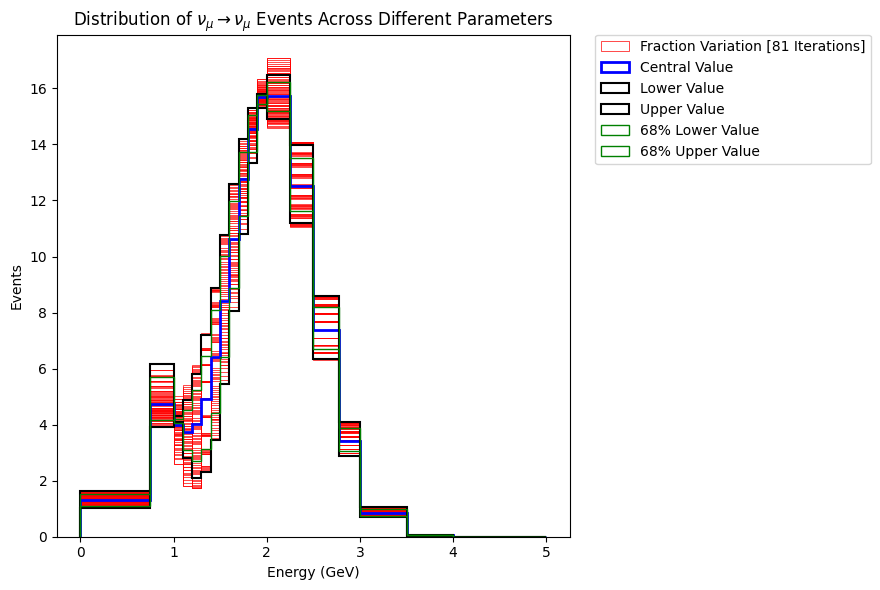

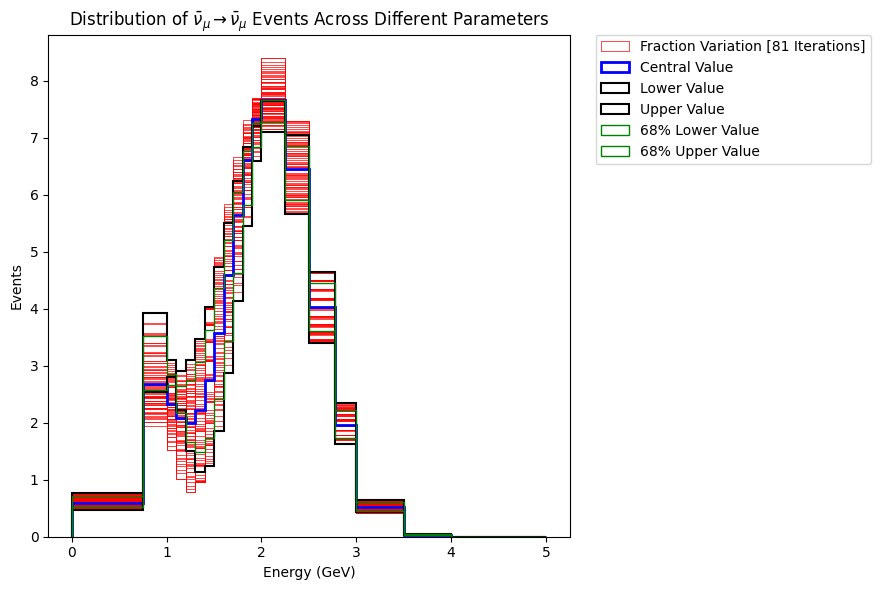

In [8]:
fractions = np.linspace(-1,1, 9)
c1, error1 = compute_error_bars(fractions)
c2, error2 = compute_error_bars_anti(fractions)


In [9]:
print(c1)
print(c2)

[1.30203450e+00 4.74743227e+00 3.99440957e+00 3.74800928e+00
 4.01094265e+00 4.90727657e+00 6.42295166e+00 8.41307136e+00
 1.06306782e+01 1.27742449e+01 1.45451242e+01 1.57026217e+01
 1.57306869e+01 1.25215198e+01 7.39258052e+00 3.42910445e+00
 8.60598020e-01 5.31953751e-02 6.78752895e-04]
[5.98561884e-01 2.67693234e+00 2.33500474e+00 2.07504426e+00
 2.00255166e+00 2.21847994e+00 2.75621170e+00 3.57930448e+00
 4.59040609e+00 5.65108745e+00 6.60919849e+00 7.32801780e+00
 7.66792174e+00 6.45587302e+00 4.02193899e+00 1.96294062e+00
 5.21712288e-01 3.55253346e-02 5.03232072e-04]


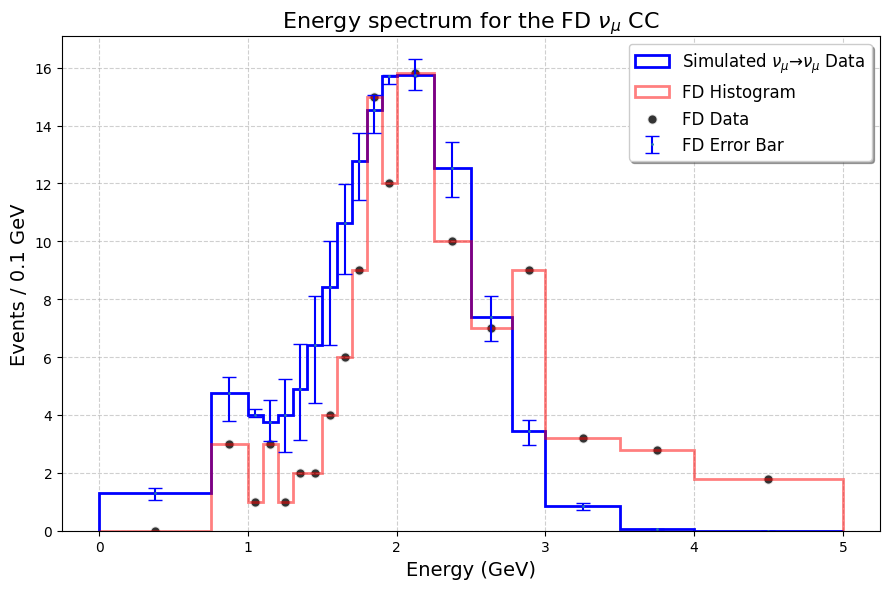

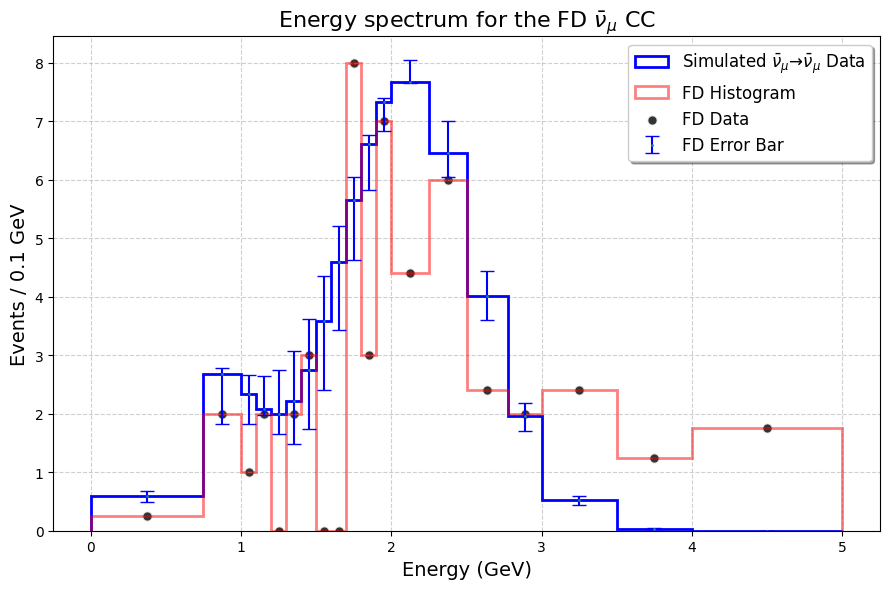

In [10]:
plt.figure(figsize=(9,6))
plt.hist(bin_edges[:-1], bin_edges, weights=c1, histtype='step', label=r'Simulated $\nu _\mu \to \nu _\mu$ Data', linewidth=2, color='b')
plt.hist(bin_edges[:-1], bin_edges,weights=counts_fd, density=False, alpha=0.5, histtype='step', color='r', label='FD Histogram', linewidth=2)
plt.scatter(bin_centers, counts_fd, color='black', label='FD Data' ,edgecolor='white', s=50, alpha=0.8, marker='o', linewidth=1.2 )
plt.errorbar(bin_centers, c1, yerr=error1, label='FD Error Bar', fmt='o', capsize=5, ecolor='blue', elinewidth=1.5, markersize=1, markerfacecolor='black')
plt.title(r'Energy spectrum for the FD $\nu _\mu$ CC', fontsize=16)
plt.ylabel('Events / 0.1 GeV', fontsize=14)
plt.xlabel('Energy (GeV)', fontsize=14)
plt.legend(fontsize=12, loc="upper right", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,6))
plt.hist(bin_edges[:-1], bin_edges, weights=c2, histtype='step', label=r'Simulated $\bar{\nu} _\mu \to \bar{\nu} _\mu$ Data', linewidth=2, color='b')
plt.hist(bin_edges[:-1], bin_edges,weights=anti_counts_fd, density=False, alpha=0.5, histtype='step', color='r', label='FD Histogram', linewidth=2)
plt.scatter(bin_centers, anti_counts_fd, color='black', label='FD Data' ,edgecolor='white', s=50, alpha=0.8, marker='o', linewidth=1.2 )
plt.errorbar(bin_centers, c2, yerr=error2, label='FD Error Bar', fmt='o', capsize=5, ecolor='blue', elinewidth=1.5, markersize=1, markerfacecolor='black')
plt.title(r'Energy spectrum for the FD $\bar{\nu} _\mu$ CC', fontsize=16)
plt.ylabel('Events / 0.1 GeV', fontsize=14)
plt.xlabel('Energy (GeV)', fontsize=14)
plt.legend(fontsize=12, loc="upper right", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [11]:
def propagate_square(value, uncertainty):
    squared_value = value ** 2
    relative_uncertainty = (2 * uncertainty) / value
    squared_uncertainty = relative_uncertainty * squared_value
    return squared_value, squared_uncertainty

# Example usage:
x = 0.6997
dx = 0.061712

y, dy = propagate_square(x, dx)
print(f"{x}^2 = {y:.3f} ± {dy:.3f}")

0.6997^2 = 0.490 ± 0.086


In [12]:
s2th23_mean= 0.692395
s2th23_std= 0.080702

y, dy = propagate_square(s2th23_mean, s2th23_std)
print(f"{s2th23_mean}^2 = {y:.3f} ± {dy:.3f}")

0.692395^2 = 0.479 ± 0.112
